In [1]:
import tensorflow as tf
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from sklearn import preprocessing

/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
sess = tf.Session()
c=tf.constant(np.array([[[1.,2.],[1.,2.]],[[3.,4.],[3.,4.]]]))
a=tf.concat([c,tf.zeros([2,2,2],tf.float64)],2)

In [11]:
sess.run(c)

array([[[1., 2.],
        [1., 2.]],

       [[3., 4.],
        [3., 4.]]])

In [18]:
sess.run(a[:,:,0:2])

array([[[1., 2.],
        [1., 2.]],

       [[3., 4.],
        [3., 4.]]])

In [15]:
a.shape.as_list()

[2, 2, 4]

In [2]:
sess = tf.Session()
a=tf.constant(np.array([[[1.,2.],[1.,2.]],[[3.,4.],[3.,4.]]]))
b=tf.constant(np.array([[[1.,2.,3.],[1.,2.,3.]],[[3.,4.,5.],[3.,4.,5.]]]))

dim0 = a.shape.as_list()[0]
dim1 = a.shape.as_list()[1]
increase_dim2 = b.shape.as_list()[2]-a.shape.as_list()[2]
zeropadding = np.zeros([dim0, dim1, increase_dim2])
c = b + tf.concat([a,zeropadding], 2)

In [3]:
sess.run(a)

array([[[1., 2.],
        [1., 2.]],

       [[3., 4.],
        [3., 4.]]])

In [4]:
sess.run(b)

array([[[1., 2., 3.],
        [1., 2., 3.]],

       [[3., 4., 5.],
        [3., 4., 5.]]])

In [5]:
sess.run(c)

array([[[2., 4., 3.],
        [2., 4., 3.]],

       [[6., 8., 5.],
        [6., 8., 5.]]])

In [2]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] , f['label'][start_idx : end_idx]
    f.close()
    
def w(shape): #weight
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='w')

def b(shape): #bias
    return tf.Variable(tf.constant(0.1,shape=shape), name='b')

def conv2d(x,w): #x:輸入影像，須為4維張量。 w:filter權重
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def maxpool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [3]:
pr = 0.8
mod = 5
traindatafile =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq1024_pr'+str(pr)+'.h5'
valdatafile = '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq1024_pr'+str(pr)+'.h5'
modelstore = '/Volumes/Mac/GW/model/model'+str(mod)+'.ckpt'
testdatafile = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr'+str(pr)+'.h5'
testdatapar = '/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr0.5.h5'

In [4]:
f = h5py.File(traindatafile, 'r')
ll = len(f['data'])
print ll

6390


In [9]:
f = h5py.File('/Volumes/Mac/GW/waveform/GWwaveform5~75_step1', 'r')
ll = len(f['data'])
print ll

2556


In [5]:
sample_rate = 8192
data_length = 8192 
T = data_length / sample_rate

nitv = 16.0
novl = 8.0
#f
lenf = int(sample_rate/nitv/2+1)
print 'lenth f =',lenf
#t
lent = int((nitv*T-1)*novl+1)
print 'lenth t =',lent
#total
totalpix = lenf*lent
print 'total',totalpix
#idx of f=1024
idx1024 = (lenf-1)/4
print 'idx1024=',idx1024


batchSize = 10
datasize = ll
totalBatchs = datasize/batchSize

c1fs = 7 #conv1 filter size
c1fn = 2 #conv1 filter number
c2fs = 5 #conv2 filter size
c2fn = 4 #conv2 filter number
c3fs = 3 #conv3 filter size
c3fn = 8 #conv3 filter number
dos1 = idx1024+1 #1st dim of spectrogram
dos2 = lent #2nd dim of spectrogram
lnn1 = 128 #layer1 neuron number
lnn2 =64 #layer1 neuron number

lenth f = 257
lenth t = 121
total 31097
idx1024= 64


In [6]:
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, dos1, dos2], name='x')
    x_image = tf.reshape(x, [-1, dos1, dos2, 1]) #(筆數,頻率維度,時間維度,顏色維度)
    
with tf.name_scope('c1_conv'):
    w1 = w([c1fs ,c1fs ,1, c1fn])
    b1 = b([c1fn])
    conv1 = conv2d(x_image, w1) + b1
    c1_conv = tf.nn.relu(conv1)
    
with tf.name_scope('c1_pool'):
    c1_pool = maxpool2x2(c1_conv)
    
with tf.name_scope('c2_conv'):
    w2 = w([c2fs ,c2fs , c1fn, c2fn])
    b2 = b([c2fn])
    conv2 = conv2d(c1_pool,w2) +b2
    c2_conv = tf.nn.relu(conv2)
    
with tf.name_scope('c2_pool'):
    c2_pool = maxpool2x2(c2_conv)
    
with tf.name_scope('c3_conv'):
    w3 = w([c3fs ,c3fs ,c2fn, c3fn])
    b3 = b([c3fn])
    conv3 = conv2d(c2_pool, w3) + b3
    c3_conv = tf.nn.relu(conv3)
    
#neurons = dos1/8*dos2/8*c3fn
with tf.name_scope('D_flat'):
    D_Flat = tf.layers.Flatten()(c3_conv)

with tf.name_scope('D_hidden_layer1'):
    inputdim = D_Flat.shape.as_list()[1]
    wl1 = w([inputdim, lnn1])
    bl1 = b([lnn1])
    D_hidden1 = tf.nn.relu(tf.matmul(D_Flat, wl1)+bl1)
    
with tf.name_scope('D_hidden_layer2'):
    wl2 = w([lnn1, lnn2])
    bl2 = b([lnn2])
    D_hidden2 = tf.nn.relu(tf.matmul(D_hidden1, wl2)+bl2)
    
with tf.name_scope('output_layer'):
    wo = w([lnn2,2])
    bo = b([2])
    #y_predict = tf.sigmoid(tf.matmul(D_hidden_dropout2,wo)+bo)
    y_predict = tf.nn.softmax(tf.matmul(D_hidden2,wo)+bo)
    
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None,2], name='y_label')
    #lossfunction = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    lossfunction = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
    
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [7]:
def evaluate(trainEpochs):
    loss_list = [] ; epoch_list = [] ; accuracy_list = []

    start_time = timeit.default_timer()
    sess = tf.Session()

    saver = tf.train.Saver()

    try: #第一次後執行
        saver.restore(sess, modelstore)
    except: #第一次跑時執行
        sess.run(tf.global_variables_initializer())


    bg = batch_generator(traindatafile, batchSize)
    fval = h5py.File(valdatafile, 'r')
    val_x = fval['data'][...]
    val_y = fval['label'][...]
    #np_utils.to_categorical
    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            #每次讀取100筆資料
            batch_x, batch_y = next(bg)
            #將feature和label輸入並計算執行圖
            sess.run(optimizer, feed_dict={x : batch_x, y_label : sess.run(tf.one_hot(batch_y, 2)) })
        #使用驗證資料計算一次epoch的loss和acc    
        loss, acc = sess.run([lossfunction,accuracy],feed_dict={x : val_x, y_label : sess.run(tf.one_hot(val_y, 2))})
    
        epoch_list.append(epoch) ; loss_list.append(loss) ; accuracy_list.append(acc)
        print 'Train Epoch:', '%02d'%(epoch+1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=',acc
    

    saver.save(sess, modelstore)

    fval.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time

def estimate(testdata):
    ftest = h5py.File(testdata, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    start_time = timeit.default_timer()
    print 'acc :', sess.run(accuracy, feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2)) })
    stop_time = timeit.default_timer()
    print 'period of estimate =', stop_time - start_time, '(s)'
    
def prediction_result(testdata):
    ftest = h5py.File(testdata, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    start_time = timeit.default_timer()
    pr = sess.run(tf.argmax(y_predict, 1), feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2))})
    stop_time = timeit.default_timer()
    print 'period of prediction =', stop_time - start_time, '(s)'
    return pr

In [8]:
evaluate(2) #pr=1.5

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model5.ckpt
Train Epoch: 01 Loss= 0.406934172 Accuracy= 0.90933335
Train Epoch: 02 Loss= 0.395069987 Accuracy= 0.915
period(s) = 262.612557888


In [9]:
evaluate(2) #pr=1.5

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model5.ckpt
Train Epoch: 01 Loss= 0.384797901 Accuracy= 0.925
Train Epoch: 02 Loss= 0.367084146 Accuracy= 0.9486667
period(s) = 489.221810102


In [10]:
evaluate(5) #1.5

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model5.ckpt
Train Epoch: 01 Loss= 0.345329255 Accuracy= 0.972
Train Epoch: 02 Loss= 0.337785780 Accuracy= 0.9776667
Train Epoch: 03 Loss= 0.332563996 Accuracy= 0.983


KeyboardInterrupt: 

In [12]:
evaluate(5) #1

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
Train Epoch: 01 Loss= 0.326502681 Accuracy= 0.9863333
Train Epoch: 02 Loss= 0.325302392 Accuracy= 0.988
Train Epoch: 03 Loss= 0.327876866 Accuracy= 0.9853333
Train Epoch: 04 Loss= 0.330673069 Accuracy= 0.9826667
Train Epoch: 05 Loss= 0.322347015 Accuracy= 0.991
period(s) = 2794.75981903


In [9]:
evaluate(5) #pr=1.2

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
Train Epoch: 01 Loss= 0.313783079 Accuracy= 0.9993333
Train Epoch: 02 Loss= 0.313746214 Accuracy= 0.9993333
Train Epoch: 03 Loss= 0.313826352 Accuracy= 0.9993333
Train Epoch: 04 Loss= 0.313550889 Accuracy= 1.0
Train Epoch: 05 Loss= 0.314091623 Accuracy= 0.9993333
period(s) = 1007.16630006


In [11]:
evaluate(5) #pr=1

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
Train Epoch: 01 Loss= 0.319688886 Accuracy= 0.99366665
Train Epoch: 02 Loss= 0.317988575 Accuracy= 0.9953333
Train Epoch: 03 Loss= 0.319385529 Accuracy= 0.9946667
Train Epoch: 04 Loss= 0.316449255 Accuracy= 0.997
Train Epoch: 05 Loss= 0.316285521 Accuracy= 0.99666667
period(s) = 11006.7617369


In [15]:
evaluate(5) #pr=

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
Train Epoch: 01 Loss= 0.427587479 Accuracy= 0.879
Train Epoch: 02 Loss= 0.433307588 Accuracy= 0.8703333
Train Epoch: 03 Loss= 0.424093634 Accuracy= 0.883
Train Epoch: 04 Loss= 0.425914347 Accuracy= 0.883
Train Epoch: 05 Loss= 0.426102042 Accuracy= 0.88133335
period(s) = 937.025388002


In [14]:
d = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5_2time10_'

In [23]:
def relation(n):
    rm = np.zeros([70,70])
    count_total = 0
    count_wrong = 0
    cm = np.zeros([2,2])
    for j in range(n):
        data =  d+str(j)+'.h5'
        test = h5py.File(data, 'r')
        test_par = test['parameter'][...]
        test_lab = test['label'][...]
        test.close()
        predict = prediction_result(data)
        cm += confusionmatrix(predict,test_lab)
        for i in range(len(test_par)):
            if test_par[i,0] != 0: #選擇有訊號的數據
                count_total += 1.
                if test_lab[i] != predict[i]: #預測不正確則顏色加深
                    row = int(test_par[i,0]-5.5)
                    col =  int(test_par[i,1]-5.5)
                    rm[row,col] += 1.
                    count_wrong +=1.
    print 'sensitivity =',(count_total-count_wrong)/count_total
    print 'acc =',acc(cm)
    print 'sensitivity =', sensitivity(cm)
    print 'far =',false_alarm_rate(cm)
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    rmr = rm.reshape(70*70,1)
    rmrn = scale.fit_transform(rmr)
    rm = rmrn.reshape(70, 70)
    return rm

def confusionmatrix(prediction_result,test_y):
    sess = tf.Session()
    cm = sess.run(tf.confusion_matrix(test_y, prediction_result))
    print 'confusionmatrix ='
    print cm
    return cm

def false_alarm_rate(cm):
    fp = cm[0,1].astype('float64')
    tn = cm[0,0].astype('float64')
    print 'false alarm rate =',fp/(fp+tn) #false alarm rate

def sensitivity(cm):
    tp = cm[1,1].astype('float64')
    fn = cm[1,0].astype('float64')
    print 'sensitivity =',tp/(tp+fn) #sensitivity
    

def acc(cm):
    print 'acc =',(cm[0,0]+cm[1,1])/np.sum(cm)
def summary():
    estimate()
    pr = prediction_result()
    cm = confusionmatrix(pr)
    false_alarm_rate(cm)
    sensitivity(cm)

In [10]:
rm = relation(50)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 20.533698082 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 20.0136342049 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 22.212143898 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 21.0090949535 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.6757888794 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.6111841202 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.2658708096 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.4742348194 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/mo

([<matplotlib.axis.XTick at 0x1a2824a650>,
 <a list of 7 Text xticklabel objects>)

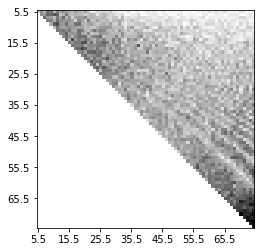

In [11]:
plt.imshow(rm, cmap='binary')
tick_idx = [0,10,20,30,40,50,60]
tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
plt.yticks(tick_idx , tick_mass)
plt.xticks(tick_idx , tick_mass) 

In [16]:
rm2 = relation(50)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 25.411965847 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 18.9637608528 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 18.8773200512 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.0978441238 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 18.8775670528 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.5179491043 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 20.3131799698 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.0117518902 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/m

([<matplotlib.axis.XTick at 0x1a1da2c910>,
 <a list of 7 Text xticklabel objects>)

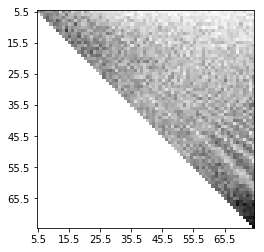

In [17]:
plt.imshow(rm2, cmap='binary')
tick_idx = [0,10,20,30,40,50,60]
tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
plt.yticks(tick_idx , tick_mass)
plt.xticks(tick_idx , tick_mass) 

In [24]:
rm3 = relation(100)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 22.7802128792 (s)
confusionmatrix =
[[ 535   17]
 [ 939 4031]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 23.4226930141 (s)
confusionmatrix =
[[ 511   41]
 [ 943 4027]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.5220189095 (s)
confusionmatrix =
[[ 526   26]
 [ 955 4015]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 21.4098260403 (s)
confusionmatrix =
[[ 520   32]
 [ 907 4063]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 23.6170661449 (s)
confusionmatrix =
[[ 526   26]
 [ 944 4026]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 22.7778811455 (s)
confusionmatrix =
[[ 520   32]
 [ 950 4020]]
INFO:tensorflow:Restoring pa

confusionmatrix =
[[ 515   37]
 [ 958 4012]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 32.4492199421 (s)
confusionmatrix =
[[ 513   39]
 [ 964 4006]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 24.1133379936 (s)
confusionmatrix =
[[ 513   39]
 [ 909 4061]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 24.0887269974 (s)
confusionmatrix =
[[ 531   21]
 [ 966 4004]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.7996180058 (s)
confusionmatrix =
[[ 526   26]
 [ 937 4033]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 19.8305590153 (s)
confusionmatrix =
[[ 523   29]
 [ 980 3990]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model3.ckpt
period of prediction = 22.9518539906 (s)
confusionmatrix =
[[ 525   2

([<matplotlib.axis.XTick at 0x1a2207d450>,
 <a list of 7 Text xticklabel objects>)

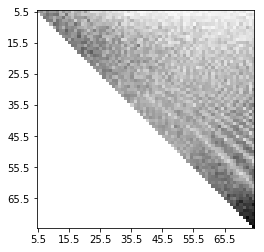

In [25]:
plt.imshow(rm3, cmap='binary')
tick_idx = [0,10,20,30,40,50,60]
tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
plt.yticks(tick_idx , tick_mass)
plt.xticks(tick_idx , tick_mass) 